# Pizza invetory tracking & optimization

### Data Loading and cleaning

In [15]:
import pandas as pd
import numpy as np
from datetime import datetime as dt, timedelta
from collections import defaultdict

# Load the pizza sales data
df = pd.read_excel('Data Model - Pizza Sales.xlsx')
df["order_date"] = pd.to_datetime(df["order_date"])

# Clean ingredient names
df['pizza_ingredients'] = df['pizza_ingredients'].str.replace('慛', 'N')
df['pizza_ingredients'] = df['pizza_ingredients'].str.replace('Artichokes', 'Artichoke')
df['pizza_ingredients'] = df['pizza_ingredients'].str.replace('Anchories', 'Anchovies')
print(f"Data loaded and cleaned with {df.shape[0]} rows and {df.shape[1]} columns.")

Data loaded and cleaned with 48620 rows and 12 columns.


### Inventory constants

In [16]:
#Dictionary with the ingredients and their mass in g per pizza
ingredient_masses_grams = {
    # meats & fish
    "Sliced Ham": 90, "Pepperoni": 80, "Bacon": 70, "Calabrese Salami": 80,
    "Capocollo": 80, "Chicken": 100, "Barbecued Chicken": 100,
    "Prosciutto di San Daniele": 60, "Prosciutto": 60,
    "Beef Chuck Roast": 110, "Italian Sausage": 100, "Chorizo Sausage": 100,
    "Soppressata Salami": 80, "Anchovies": 35,
    "Genoa Salami": 80, "Coarse Sicilian Salami": 80,
    "Luganega Sausage": 100, "Pancetta": 70, "Nduja Salami": 70,
    # cheeses
    "Mozzarella Cheese": 130, "Provolone Cheese": 90, "Smoked Gouda Cheese": 90,
    "Romano Cheese": 25, "Blue Cheese": 60, "Feta Cheese": 70,
    "Asiago Cheese": 70, "Goat Cheese": 60, "Ricotta Cheese": 80,
    "Gorgonzola Piccante Cheese": 60, "Parmigiano Reggiano Cheese": 25,
    "Fontina Cheese": 90, "Gouda Cheese": 90, "Brie Carre Cheese": 60,
    # vegetables & herbs
    "Mushrooms": 70, "Red Onions": 50, "Onions": 50, "Caramelized Onions": 60,
    "Red Peppers": 70, "Green Peppers": 70, "Friggitello Peppers": 40,
    "Jalapeno Peppers": 25, "Peperoncini verdi": 25,
    "Tomatoes": 80, "Plum Tomatoes": 80, "Sun-dried Tomatoes": 35,
    "Spinach": 40, "Arugula": 20, "Artichoke": 70,
    "Zucchini": 70, "Eggplant": 70, "Garlic": 6, "Oregano": 2,
    "Kalamata Olives": 45, "Green Olives": 45, "Pineapple": 80, "Corn": 60,
    "Cilantro": 3, "Pears": 60, "Thyme": 1,
    # sauces
    "Chipotle Sauce": 50, "Barbecue Sauce": 70, "Alfredo Sauce": 80,
    "Pesto Sauce": 50, "Thai Sweet Chilli Sauce": 45,
}

# Convert to kg for calculations
ingredient_masses_kg = {k: v / 1000 for k, v in ingredient_masses_grams.items()}

print(f"Ingredient masses defined for {len(ingredient_masses_kg)} ingredients")


Ingredient masses defined for 64 ingredients


In [17]:
# Shelf life in days for each ingredient
shelf_life_days = {
    "Sliced Ham": 5, "Pepperoni": 14, "Bacon": 7, "Calabrese Salami": 14,
    "Capocollo": 10, "Chicken": 5, "Barbecued Chicken": 5,
    "Prosciutto di San Daniele": 10, "Prosciutto": 10,
    "Beef Chuck Roast": 5, "Italian Sausage": 7, "Chorizo Sausage": 10,
    "Soppressata Salami": 14, "Anchovies": 30,
    "Genoa Salami": 14, "Coarse Sicilian Salami": 14,
    "Luganega Sausage": 7, "Pancetta": 10, "Nduja Salami": 10,
    "Mozzarella Cheese": 7, "Provolone Cheese": 14, "Smoked Gouda Cheese": 14,
    "Romano Cheese": 30, "Blue Cheese": 10, "Feta Cheese": 7,
    "Asiago Cheese": 14, "Goat Cheese": 7, "Ricotta Cheese": 7,
    "Gorgonzola Piccante Cheese": 10, "Parmigiano Reggiano Cheese": 30,
    "Fontina Cheese": 14, "Gouda Cheese": 14, "Brie Carre Cheese": 7,
    "Mushrooms": 3, "Red Onions": 14, "Onions": 14, "Caramelized Onions": 5,
    "Red Peppers": 5, "Green Peppers": 5, "Friggitello Peppers": 5,
    "Jalapeno Peppers": 7, "Peperoncini verdi": 7,
    "Tomatoes": 5, "Plum Tomatoes": 5, "Sun-dried Tomatoes": 30,
    "Spinach": 3, "Arugula": 3, "Artichoke": 5,
    "Zucchini": 5, "Eggplant": 5, "Garlic": 30, "Oregano": 30,
    "Kalamata Olives": 30, "Green Olives": 30, "Pineapple": 5, "Corn": 7,
    "Cilantro": 3, "Pears": 7, "Thyme": 30,
    "Chipotle Sauce": 30, "Barbecue Sauce": 30, "Alfredo Sauce": 7,
    "Pesto Sauce": 7, "Thai Sweet Chilli Sauce": 30,
}
print(f"Shelf life defined for {len(shelf_life_days)} ingredients")


Shelf life defined for 64 ingredients


In [18]:
#pizza recipes 
df['ingredient_list'] = df['pizza_ingredients'].str.split(',').apply(lambda lst: [ing.strip() for ing in lst])
recipes_dict = df[['pizza_name','ingredient_list']].drop_duplicates('pizza_name').set_index('pizza_name')['ingredient_list'].to_dict()
print(f"There are {len(recipes_dict)} individual pizzas")
print(recipes_dict)

There are 32 individual pizzas
{'The Hawaiian Pizza': ['Sliced Ham', 'Pineapple', 'Mozzarella Cheese'], 'The Classic Deluxe Pizza': ['Pepperoni', 'Mushrooms', 'Red Onions', 'Red Peppers', 'Bacon'], 'The Five Cheese Pizza': ['Mozzarella Cheese', 'Provolone Cheese', 'Smoked Gouda Cheese', 'Romano Cheese', 'Blue Cheese', 'Garlic'], 'The Italian Supreme Pizza': ['Calabrese Salami', 'Capocollo', 'Tomatoes', 'Red Onions', 'Green Olives', 'Garlic'], 'The Mexicana Pizza': ['Tomatoes', 'Red Peppers', 'Jalapeno Peppers', 'Red Onions', 'Cilantro', 'Corn', 'Chipotle Sauce', 'Garlic'], 'The Thai Chicken Pizza': ['Chicken', 'Pineapple', 'Tomatoes', 'Red Peppers', 'Thai Sweet Chilli Sauce'], 'The Prosciutto and Arugula Pizza': ['Prosciutto di San Daniele', 'Arugula', 'Mozzarella Cheese'], 'The Barbecue Chicken Pizza': ['Barbecued Chicken', 'Red Peppers', 'Green Peppers', 'Tomatoes', 'Red Onions', 'Barbecue Sauce'], 'The Greek Pizza': ['Kalamata Olives', 'Feta Cheese', 'Tomatoes', 'Garlic', 'Beef Chuc

### Daily pizza demand

In [19]:
# Calculate daily pizza demand
daily_demand_pizzas = df.set_index('order_date').groupby('pizza_name')['quantity'].resample('D').sum().unstack(level=0).fillna(0)
print(f"Daily pizza demand calculated for {len(daily_demand_pizzas)} days")
daily_demand_pizzas


Daily pizza demand calculated for 365 days


pizza_name,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,11.0,5.0,0.0,1.0,4.0,2.0,4.0,10.0,7.0,6.0,...,4.0,4.0,1.0,7.0,5.0,2.0,5.0,2.0,8.0,3.0
2015-01-02,9.0,8.0,0.0,0.0,5.0,1.0,2.0,6.0,6.0,3.0,...,4.0,6.0,4.0,6.0,11.0,2.0,8.0,4.0,9.0,5.0
2015-01-03,7.0,8.0,1.0,1.0,12.0,5.0,3.0,5.0,4.0,7.0,...,7.0,7.0,1.0,5.0,4.0,6.0,2.0,2.0,10.0,7.0
2015-01-04,11.0,0.0,2.0,2.0,5.0,5.0,1.0,4.0,4.0,4.0,...,5.0,3.0,0.0,1.0,6.0,3.0,4.0,4.0,5.0,1.0
2015-01-05,2.0,4.0,2.0,0.0,8.0,9.0,2.0,9.0,6.0,5.0,...,3.0,6.0,2.0,4.0,3.0,4.0,2.0,3.0,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,4.0,5.0,1.0,1.0,3.0,0.0,3.0,8.0,2.0,4.0,...,1.0,4.0,1.0,2.0,4.0,3.0,1.0,1.0,5.0,9.0
2015-12-28,2.0,3.0,1.0,1.0,5.0,2.0,3.0,9.0,2.0,4.0,...,5.0,4.0,5.0,3.0,2.0,2.0,2.0,3.0,6.0,3.0
2015-12-29,4.0,6.0,1.0,2.0,6.0,1.0,1.0,3.0,3.0,3.0,...,3.0,2.0,3.0,1.0,3.0,4.0,0.0,1.0,5.0,1.0


### Daily ingredient demand 

In [20]:
def calculate_daily_ingredient_usage(daily_demand_pizzas, recipes_dict, ingredient_masses_kg): #Returns dataframe ingredient_usage
    """
    Convert daily pizza demand to daily ingredient usage.
    
    Parameters:
    - daily_demand_pizzas: DataFrame with dates as index and pizza names as columns
    - recipes_dict: Dictionary mapping pizza names to their ingredient lists
    - ingredient_masses_kg: Dictionary mapping ingredients to their mass per pizza in kg
    
    Returns:
    - DataFrame with dates as index and ingredients as columns showing daily usage in kg
    """
    
    # Get all unique ingredients from recipes
    all_ingredients = set()
    for ingredients in recipes_dict.values():
        all_ingredients.update(ingredients)
    all_ingredients = sorted(list(all_ingredients))
    
    # Initialize ingredient usage dataframe
    ingredient_usage = pd.DataFrame(index=daily_demand_pizzas.index, columns=all_ingredients, dtype=float).fillna(0.0)
    
    # Calculate daily ingredient usage
    for date in daily_demand_pizzas.index:
        for pizza_name in daily_demand_pizzas.columns:
            pizza_quantity = daily_demand_pizzas.loc[date, pizza_name]
            
            if pizza_quantity > 0 and pizza_name in recipes_dict:
                for ingredient in recipes_dict[pizza_name]:
                    if ingredient in ingredient_masses_kg:
                        total_mass = pizza_quantity * ingredient_masses_kg[ingredient]
                        ingredient_usage.loc[date, ingredient] += total_mass
    
    return ingredient_usage
print('Function created')

Function created


In [21]:
# Calculate daily ingredient usage
daily_ingredient_usage = calculate_daily_ingredient_usage(daily_demand_pizzas, recipes_dict, ingredient_masses_kg)

print(f"Daily ingredient usage calculated: {daily_ingredient_usage.shape}")
print(f"Total ingredients tracked: {len(daily_ingredient_usage.columns)}")
daily_ingredient_usage

Daily ingredient usage calculated: (365, 64)
Total ingredients tracked: 64


,Alfredo Sauce,Anchovies,Artichoke,Arugula,Asiago Cheese,Bacon,Barbecue Sauce,Barbecued Chicken,Beef Chuck Roast,Blue Cheese,...,Romano Cheese,Sliced Ham,Smoked Gouda Cheese,Soppressata Salami,Spinach,Sun-dried Tomatoes,Thai Sweet Chilli Sauce,Thyme,Tomatoes,Zucchini
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.16,0.070,1.47,0.08,0.77,1.05,0.77,1.1,0.55,0.42,...,0.175,0.36,0.63,0.08,1.20,0.175,0.360,0.000,8.16,0.35
2015-01-02,0.08,0.210,2.17,0.08,0.91,0.98,0.63,0.9,0.77,0.36,...,0.150,0.90,0.54,0.32,1.12,0.105,0.405,0.000,8.00,0.63
2015-01-03,0.40,0.210,2.10,0.14,0.84,0.91,0.49,0.7,0.77,0.24,...,0.100,0.72,0.36,0.08,1.44,0.315,0.450,0.001,6.80,0.70
2015-01-04,0.40,0.175,1.47,0.10,0.70,0.28,0.77,1.1,0.44,0.24,...,0.100,0.36,0.36,0.00,0.84,0.105,0.225,0.002,5.04,0.28
2015-01-05,0.72,0.175,1.47,0.06,1.05,0.91,0.14,0.2,0.22,0.36,...,0.150,0.45,0.54,0.16,0.96,0.175,0.270,0.002,4.72,0.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,0.00,0.105,0.77,0.02,0.28,0.91,0.28,0.4,0.33,0.12,...,0.050,0.45,0.18,0.08,0.84,0.105,0.225,0.001,4.32,0.63
2015-12-28,0.16,0.140,0.91,0.10,0.42,0.84,0.14,0.2,0.22,0.12,...,0.050,0.63,0.18,0.40,0.84,0.070,0.270,0.001,4.00,0.35
2015-12-29,0.08,0.140,0.98,0.06,0.21,0.63,0.28,0.4,0.22,0.18,...,0.075,0.36,0.27,0.24,0.60,0.175,0.225,0.001,3.04,0.07


### Calculation of initial Inventory parameters

In [46]:
def calculate_initial_inventory_parameters(daily_ingredient_usage, ingredient_masses_kg, shelf_life_days):
    """
    Calculate all inventory parameters for each ingredient according to specifications:
    - Initial stock: Total demand in first 2 weeks * 2.2
    - Maximum stock: Max daily demand in first 3 months * 0.95
    - Minimum stock: Max daily demand in first 3 months (manually triggered)
    - Shelf life: From predefined dictionary
    
    Parameters:
    - daily_ingredient_usage: DataFrame with daily ingredient usage in kg
    - ingredient_masses_kg: Dictionary with ingredient masses per pizza in kg
    - shelf_life_days: Dictionary with shelf life for each ingredient in days
    
    Returns:
    - DataFrame with all inventory parameters
    """
    
    # Filter first two weeks for initial stock calculation
    first_two_weeks = daily_ingredient_usage[
        (daily_ingredient_usage.index >= '2015-01-01') & 
        (daily_ingredient_usage.index < '2015-01-15')
    ]
    
    # Filter first three months for max/min stock calculation
    first_three_months = daily_ingredient_usage[
        (daily_ingredient_usage.index >= '2015-01-01') & 
        (daily_ingredient_usage.index < '2015-04-01')
    ]
    
    # Calculate parameters for each ingredient
    inventory_parameters = []
    
    for ingredient in daily_ingredient_usage.columns:
        # Initial stock: total demand in first 2 weeks * 2.2
        initial_stock = first_two_weeks[ingredient].sum() * 1.53
        
        # Maximum stock: max daily demand in first 3 months * 0.95
        max_daily_demand = first_three_months[ingredient].max()
        max_stock = max_daily_demand * 1.49
        
        # Minimum stock: same as max daily demand (manually triggered)
        min_stock = max_daily_demand*0.41
        
        # Shelf life
        shelf_life = shelf_life_days.get(ingredient, 7)  # default 7 days
        
        inventory_parameters.append({
            'ingredient': ingredient,
            'initial_stock_kg': initial_stock,
            'max_stock_kg': max_stock,
            'min_stock_kg': min_stock,
            'shelf_life_days': shelf_life,
            'mass_per_pizza_kg': ingredient_masses_kg.get(ingredient, 0)
        })
    
    return pd.DataFrame(inventory_parameters).set_index('ingredient')

# Calculate inventory parameters
inventory_parameters = calculate_initial_inventory_parameters(daily_ingredient_usage, ingredient_masses_kg, shelf_life_days)

print("Inventory parameters calculated:")
print(inventory_parameters)
print(f"\nTotal ingredients: {len(inventory_parameters)}")


Inventory parameters calculated:
                         initial_stock_kg  max_stock_kg  min_stock_kg  \
ingredient                                                              
Alfredo Sauce                     5.63040       1.07280       0.29520   
Anchovies                         3.05235       0.46935       0.12915   
Artichoke                        32.77260       4.38060       1.20540   
Arugula                           1.83600       0.29800       0.08200   
Asiago Cheese                    16.27920       2.08600       0.57400   
...                                   ...           ...           ...   
Sun-dried Tomatoes                3.32010       0.62580       0.17220   
Thai Sweet Chilli Sauce           6.19650       0.87165       0.23985   
Thyme                             0.01989       0.00745       0.00205   
Tomatoes                        134.76240      12.39680       3.41120   
Zucchini                         11.45970       1.56450       0.43050   

                 

### Invetory simulation function

In [ ]:
def simulate_inventory(df, inventory_parameters, recipes_dict, ingredient_masses_kg, 
                      start_date='2015-01-01', end_date='2015-04-01',
                      restock_interval_days=7, alarm_threshold=3):
    """
    Same I/O and logic as your version:
    - FEFO consumption
    - Weekly + interval restocks
    - Weekly alarm threshold shortens interval
    - Counts safety_stock_alarms
    Returns a dict with: lost_demand, waste_kg (per ingredient), waste_total_kg,
    restock_events, final_restock_interval_days, safety_stock_alarms
    """

    # --- Prep dates and a simple working copy of sales ---
    df_sim = df.copy()
    df_sim["date"] = pd.to_datetime(df_sim["order_date"]).dt.date
    days = pd.date_range(start_date, end_date, freq="D").date
    start_day = days[0]

    # --- Read parameters as plain dicts ---
    min_stock   = {k: float(v) for k, v in inventory_parameters['min_stock_kg'].items()}
    max_stock   = {k: float(v) for k, v in inventory_parameters['max_stock_kg'].items()}
    shelf_life  = {k: int(v)   for k, v in inventory_parameters['shelf_life_days'].items()}

    # --- Inventory structure: {ingredient: [(amount_kg, expiry_date), ...]} ---
    inventory = {}
    for ing in inventory_parameters.index:
        init_amt = float(inventory_parameters.loc[ing, 'initial_stock_kg'])
        exp_date = start_day + timedelta(days=int(inventory_parameters.loc[ing, 'shelf_life_days']))
        inventory[ing] = [(init_amt, exp_date)]

    # --- Tracking ---
    lost_demand = 0
    waste = defaultdict(float)
    weekly_alarms = 0
    safety_stock_alarms = 0
    restock_events = 0
    current_restock_interval = int(restock_interval_days)
    week_start = start_day

    # --- Helpers (kept simple) ---
    def get_current_stock(ingredient):
        total = 0.0
        for amt, _ in inventory.get(ingredient, []):
            total += float(amt)
        return float(total)

    def remove_expired(today):
        for ing in list(inventory.keys()):
            new_batches = []
            for amt, exp in inventory[ing]:
                if today >= exp:
                    waste[ing] += float(amt)
                else:
                    new_batches.append((float(amt), exp))
            inventory[ing] = new_batches

    def consume_fefo(ingredient, needed_amount):
        # Sort batches by soonest expiry first
        if ingredient not in inventory:
            return False
        inventory[ingredient].sort(key=lambda t: t[1])

        remaining_need = float(needed_amount)
        new_batches = []

        for amt, exp in inventory[ingredient]:
            if remaining_need <= 0:
                new_batches.append((amt, exp))
                continue
            use = min(float(amt), remaining_need)
            left = float(amt) - use
            remaining_need -= use
            if left > 1e-9:
                new_batches.append((left, exp))

        inventory[ingredient] = new_batches
        return remaining_need <= 1e-9

    # --- Simulation loop day by day ---
    for day in days:
        # 1) Expiry cleanup → waste
        remove_expired(day)

        # 2) Fulfil orders of the day
        day_orders = df_sim[df_sim["date"] == day]
        for _, order in day_orders.iterrows():
            pizza = order['pizza_name']
            qty = int(order['quantity'])

            if pizza not in recipes_dict:
                continue

            # Build needed ingredient amounts for this order
            needed = {}
            can_fulfill = True
            for ing in recipes_dict[pizza]:
                amt_needed = float(qty) * float(ingredient_masses_kg[ing])
                needed[ing] = amt_needed
                if get_current_stock(ing) < amt_needed:
                    can_fulfill = False
                    break

            if can_fulfill:
                # Consume all needed ingredients using FEFO
                for ing, amt_needed in needed.items():
                    ok = consume_fefo(ing, amt_needed)
                    if not ok:
                        can_fulfill = False
                        break

            if not can_fulfill:
                lost_demand += 1

        # 3) Manual low-stock alarms
        for ing in list(inventory.keys()):
            curr = get_current_stock(ing)
            thr = float(min_stock.get(ing, 0.0))
            if curr <= thr:
                weekly_alarms += 1
                safety_stock_alarms += 1

        # 4) Restock checks
        restock_today = False

        # Weekly Monday restock
        if day.weekday() == 0:
            restock_today = True

        # Interval-based restock from start day
        days_since_start = (day - start_day).days
        if days_since_start % current_restock_interval == 0:
            restock_today = True

        if restock_today:
            restock_events += 1
            for ing in inventory_parameters.index:
                target = float(max_stock.get(ing, 0.0))
                curr = get_current_stock(ing)
                add = max(0.0, target - curr)
                if add > 0.0:
                    exp = day + timedelta(days=int(shelf_life.get(ing, 7)))
                    inventory[ing].append((add, exp))

        # 5) Weekly interval adjustment
        if day >= week_start + timedelta(days=6):
            if weekly_alarms >= int(alarm_threshold):
                current_restock_interval = max(3, current_restock_interval - 1)
            weekly_alarms = 0
            week_start = day + timedelta(days=1)

    return {
        'lost_demand': int(lost_demand),
        'waste_kg': dict(waste),
        'waste_total_kg': round(float(sum(waste.values())), 3),
        'restock_events': int(restock_events),
        'final_restock_interval_days': int(current_restock_interval),
        'safety_stock_alarms': int(safety_stock_alarms)
    }


### Testing of Simulation function

In [82]:
# === Run simulations with different restock intervals ===
restock_intervals = [1,2,3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
simulation_results = []

for interval in restock_intervals:
    result = simulate_inventory(
        df=df,
        inventory_parameters=inventory_parameters,
        recipes_dict=recipes_dict,
        ingredient_masses_kg=ingredient_masses_kg,
        start_date='2015-01-01',
        end_date='2015-03-31',
        restock_interval_days=interval,
        alarm_threshold=3
    )
    result['restock_interval_days'] = interval
    simulation_results.append(result)

# turn into DataFrame
results_df = pd.json_normalize(simulation_results)
results_df = results_df.set_index("restock_interval_days").sort_index()

# expand waste_kg dict into columns
if "waste_kg" in results_df.columns:
    waste_df = pd.DataFrame(results_df.pop("waste_kg").tolist(),
                            index=results_df.index).add_prefix("waste_kg_")
    results_df = results_df.join(waste_df)

# show selected outputs
print("Simulation Results:")
print(results_df[["lost_demand","waste_total_kg","restock_events",
                  "safety_stock_alarms","final_restock_interval_days"]])


Simulation Results:
                       lost_demand  waste_total_kg  restock_events  \
restock_interval_days                                                
1                             3083         766.902              42   
2                             3241         797.736              39   
3                             3182         781.278              39   
4                             3313         794.566              37   
5                             3035         755.590              38   
6                             3247         810.153              38   
7                             3720         819.866              35   
8                             4506         838.799              31   
9                             3836         805.920              34   
10                            3949         819.097              33   
11                            5319         882.448              29   
12                            4460         839.021              30   


In [79]:
# Sum of all ingredient masses used throughout the whole year
total_ingredient_usage_year = daily_ingredient_usage.loc['2015-01-01':'2015-12-31'].sum()
grand_total_usage = total_ingredient_usage_year.sum()
grand_total_usage

16931.997000000003

In [80]:
waste_percentage = results_df['waste_total_kg'].min() / grand_total_usage*100
waste_percentage

6.3237785832350415

In [81]:
lost_demand_percentage = results_df['lost_demand'].min() / df['quantity'].sum()*100
lost_demand_percentage

23.8411263969016

49574

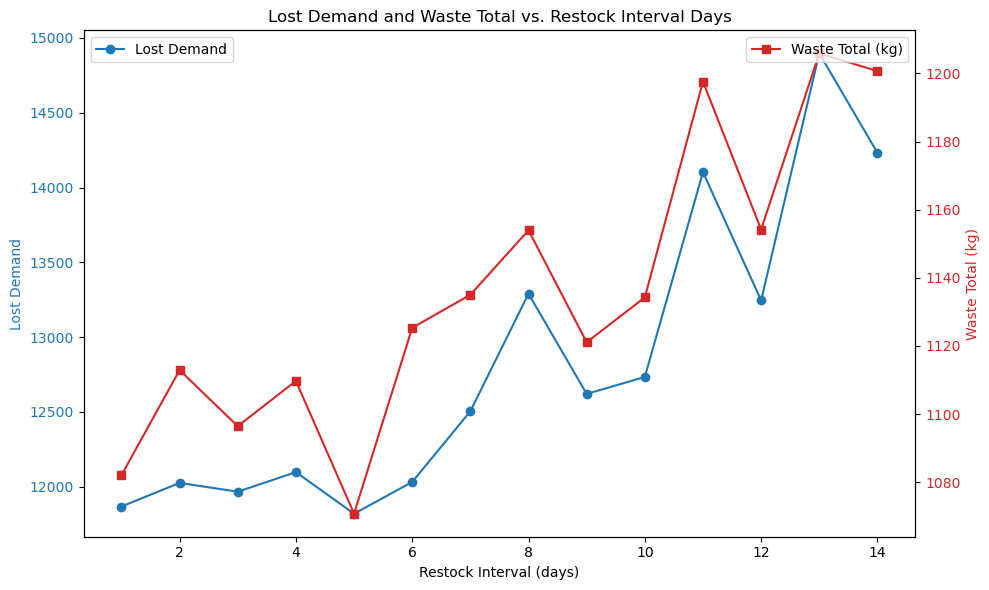

In [45]:
# Bayesian Optimization for inventory parameters using Optuna

import optuna

def objective(trial):
    # Suggest factors for initial, min, and max stock
    init_factor = trial.suggest_float('init_factor', 1.0, 3.0)
    min_factor = trial.suggest_float('min_factor', 0.1, 0.5)
    max_factor = trial.suggest_float('max_factor', 0.7, 1.5)
    alpha = 1.0  # weight for waste in the score

    # Generate new inventory parameters
    def custom_inventory_params(daily_ingredient_usage, ingredient_masses_kg, shelf_life_days):
        first_two_weeks = daily_ingredient_usage[
            (daily_ingredient_usage.index >= '2015-01-01') & 
            (daily_ingredient_usage.index < '2015-01-15')
        ]
        first_three_months = daily_ingredient_usage[
            (daily_ingredient_usage.index >= '2015-01-01') & 
            (daily_ingredient_usage.index < '2015-04-01')
        ]
        inventory_parameters = []
        for ingredient in daily_ingredient_usage.columns:
            initial_stock = first_two_weeks[ingredient].sum() * init_factor
            max_daily_demand = first_three_months[ingredient].max()
            max_stock = max_daily_demand * max_factor
            min_stock = max_daily_demand * min_factor
            shelf_life = shelf_life_days.get(ingredient, 7)
            inventory_parameters.append({
                'ingredient': ingredient,
                'initial_stock_kg': initial_stock,
                'max_stock_kg': max_stock,
                'min_stock_kg': min_stock,
                'shelf_life_days': shelf_life,
                'mass_per_pizza_kg': ingredient_masses_kg.get(ingredient, 0)
            })
        return pd.DataFrame(inventory_parameters).set_index('ingredient')

    # Calculate parameters and run simulation
    params = custom_inventory_params(daily_ingredient_usage, ingredient_masses_kg, shelf_life_days)
    result = simulate_inventory(
        df=df,
        inventory_parameters=params,
        recipes_dict=recipes_dict,
        ingredient_masses_kg=ingredient_masses_kg,
        start_date='2015-01-01',
        end_date='2015-04-01',
        restock_interval_days=7,
        alarm_threshold=2
    )
    score = result['lost_demand'] + alpha * result['waste_total_kg']
    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

[I 2025-09-12 16:26:12,099] A new study created in memory with name: no-name-9258f93a-89b8-4639-81c0-57acc5d83250
[I 2025-09-12 16:26:16,005] Trial 0 finished with value: 6018.333 and parameters: {'init_factor': 1.3909647893708628, 'min_factor': 0.32493792325399107, 'max_factor': 1.0881897193268886}. Best is trial 0 with value: 6018.333.
[I 2025-09-12 16:26:17,765] Trial 1 finished with value: 6098.274 and parameters: {'init_factor': 1.8590273509142146, 'min_factor': 0.35844217700405234, 'max_factor': 1.1418528998241697}. Best is trial 0 with value: 6018.333.
[I 2025-09-12 16:26:19,540] Trial 2 finished with value: 6333.409 and parameters: {'init_factor': 2.0105455326310793, 'min_factor': 0.1270467921159542, 'max_factor': 1.10652773231242}. Best is trial 0 with value: 6018.333.
[I 2025-09-12 16:26:21,325] Trial 3 finished with value: 4613.333 and parameters: {'init_factor': 1.3092330364996807, 'min_factor': 0.33512175690146406, 'max_factor': 1.4238913759498515}. Best is trial 3 with va

Best parameters: {'init_factor': 1.5307479557668828, 'min_factor': 0.4193414582400159, 'max_factor': 1.4961476588882632}
Best score: 4537.092
